In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from numpy import var

# Step 1: Load the cleaned data
df = pd.read_csv('weather_data_monthly.csv', index_col='utc_timestamp', parse_dates=True)

# Focus on a specific country, e.g., DE (Germany)
country_code = 'DE'
temperature_col = f"{country_code}_temperature"
radiation_cols = [f"{country_code}_radiation_direct_horizontal", f"{country_code}_radiation_diffuse_horizontal"]


In [6]:
# Step 2: Create cyclical features for the month
df['month'] = df.index.month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Create a time trend (e.g., number of months since the start of the dataset)
df['time_trend'] = np.arange(len(df))


In [7]:
# Step 3: Split the data into training and testing sets (80/20 split)
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)

# Step 4: Train the linear regression model for temperature with time trend and month_sin, month_cos
X_train_temp = train_df[['time_trend', 'month_sin', 'month_cos'] + radiation_cols]
y_train_temp = train_df[temperature_col]
X_test_temp = test_df[['time_trend', 'month_sin', 'month_cos'] + radiation_cols]
y_test_temp = test_df[temperature_col]

# Fit the temperature model
model_temp = LinearRegression()
model_temp.fit(X_train_temp, y_train_temp)

# Make predictions for temperature
y_pred_temp = model_temp.predict(X_test_temp)

In [8]:
# Step 5: Train separate models for direct and diffuse radiation with time trend and month_sin, month_cos
X_train_rad = train_df[['time_trend', 'month_sin', 'month_cos']]
X_test_rad = test_df[['time_trend', 'month_sin', 'month_cos']]

model_direct_rad = LinearRegression()
model_diffuse_rad = LinearRegression()

y_train_direct_rad = train_df[radiation_cols[0]]
y_train_diffuse_rad = train_df[radiation_cols[1]]

# Fit the radiation models
model_direct_rad.fit(X_train_rad, y_train_direct_rad)
model_diffuse_rad.fit(X_train_rad, y_train_diffuse_rad)

# Make predictions for radiation
y_pred_direct_rad = model_direct_rad.predict(X_test_rad)
y_pred_diffuse_rad = model_diffuse_rad.predict(X_test_rad)


In [11]:
# Step 6: Evaluate the models
mse_temp = mean_squared_error(y_test_temp, y_pred_temp)
mse_direct_rad = mean_squared_error(test_df[radiation_cols[0]], y_pred_direct_rad)
mse_diffuse_rad = mean_squared_error(test_df[radiation_cols[1]], y_pred_diffuse_rad)

# Calculate variance of the actual test data
var_temp = var(y_test_temp)
var_direct_rad = var(test_df[radiation_cols[0]])
var_diffuse_rad = var(test_df[radiation_cols[1]])

# Print MSE and variance for temperature
print(f"Mean Squared Error (Temperature): {mse_temp}")
print(f"Variance (Temperature): {var_temp}")

# Print MSE and variance for direct radiation
print(f"Mean Squared Error (Direct Radiation): {mse_direct_rad}")
print(f"Variance (Direct Radiation): {var_direct_rad}")

# Print MSE and variance for diffuse radiation
print(f"Mean Squared Error (Diffuse Radiation): {mse_diffuse_rad}")
print(f"Variance (Diffuse Radiation): {var_diffuse_rad}")

Mean Squared Error (Temperature): 2.367653871418158
Variance (Temperature): 48.142591116542
Mean Squared Error (Direct Radiation): 291.17053912157104
Variance (Direct Radiation): 3455.40484239896
Mean Squared Error (Diffuse Radiation): 42.46126029451143
Variance (Diffuse Radiation): 976.3080384300168


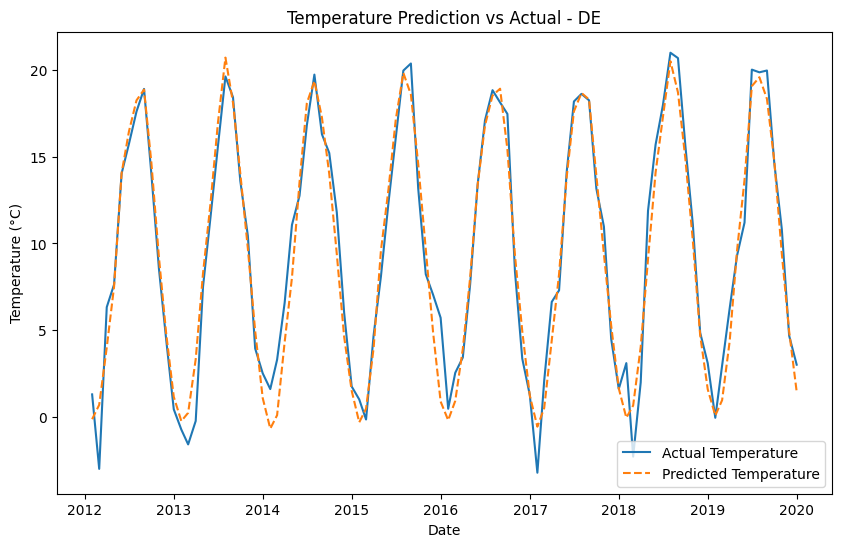

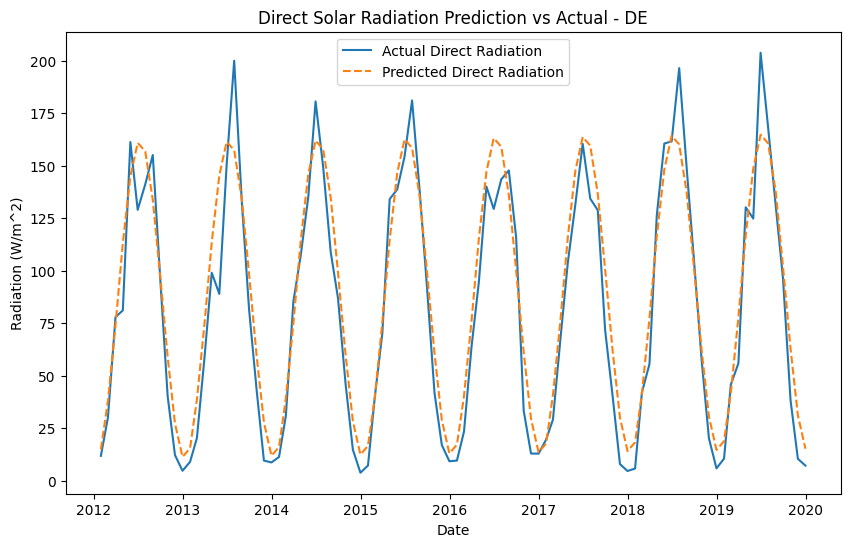

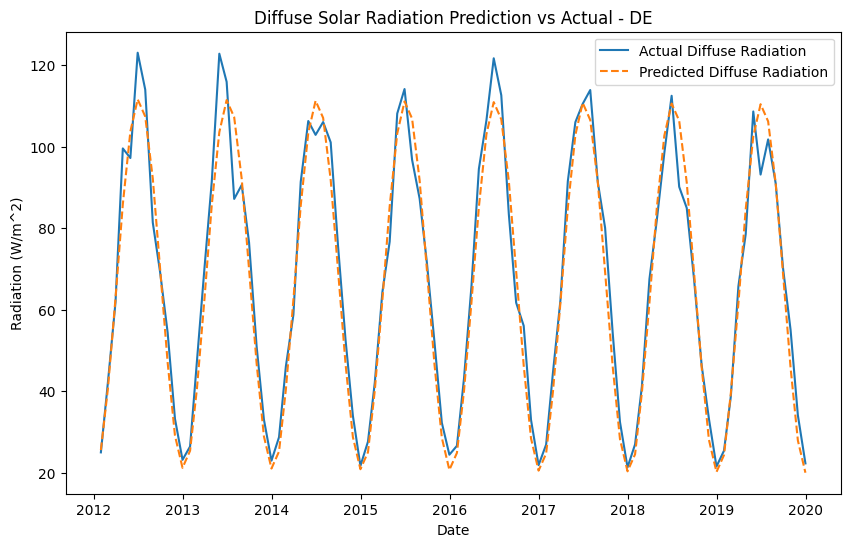

In [23]:
# Step 7: Visualize the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(test_df.index, y_test_temp, label='Actual Temperature')
plt.plot(test_df.index, y_pred_temp, label='Predicted Temperature', linestyle='--')
plt.title(f"Temperature Prediction vs Actual - {country_code}")
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(test_df.index, test_df[radiation_cols[0]], label='Actual Direct Radiation')
plt.plot(test_df.index, y_pred_direct_rad, label='Predicted Direct Radiation', linestyle='--')
plt.title(f"Direct Solar Radiation Prediction vs Actual - {country_code}")
plt.xlabel('Date')
plt.ylabel('Radiation (W/m^2)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(test_df.index, test_df[radiation_cols[1]], label='Actual Diffuse Radiation')
plt.plot(test_df.index, y_pred_diffuse_rad, label='Predicted Diffuse Radiation', linestyle='--')
plt.title(f"Diffuse Solar Radiation Prediction vs Actual - {country_code}")
plt.xlabel('Date')
plt.ylabel('Radiation (W/m^2)')
plt.legend()
plt.show()

# PREDICTING THE FUTURE

In [35]:
# Step 1: Load the cleaned data
df = pd.read_csv('weather_data_monthly.csv', index_col='utc_timestamp', parse_dates=True)

# Extract the country codes
country_codes = set([col.split('_')[0] for col in df.columns if '_' in col])

# Step 2: Prepare the DataFrame to store future predictions
future_predictions = pd.DataFrame()

In [ ]:
# Step 3: Predict for each country
for country_code in country_codes:
    temperature_col = f"{country_code}_temperature"
    radiation_cols = [f"{country_code}_radiation_direct_horizontal", f"{country_code}_radiation_diffuse_horizontal"]

    # Debugging: Check if the columns exist
    if not all(col in df.columns for col in [temperature_col] + radiation_cols):
        print(f"Skipping {country_code}: Required columns not found.")
        continue

    # Drop any missing values for simplicity
    country_df = df[[temperature_col] + radiation_cols].dropna()

    # Ensure the columns are still present after dropping missing values
    if country_df.empty:
        print(f"Skipping {country_code}: No data left after dropping missing values.")
        continue

    # Create cyclical features for month and a time trend
    country_df['month'] = country_df.index.month
    country_df['month_sin'] = np.sin(2 * np.pi * country_df['month'] / 12)
    country_df['month_cos'] = np.cos(2 * np.pi * country_df['month'] / 12)
    country_df['time'] = np.arange(len(country_df))  # Time trend

    # Train the temperature model on the full dataset using cyclical features and the time trend
    X_temp = country_df[['month_sin', 'month_cos', 'time']]
    y_temp = country_df[temperature_col]

    model_temp = LinearRegression()
    model_temp.fit(X_temp, y_temp)

    # Train radiation models
    model_direct_rad = LinearRegression()
    model_direct_rad.fit(country_df[['month_sin', 'month_cos', 'time']], country_df[radiation_cols[0]])

    model_diffuse_rad = LinearRegression()
    model_diffuse_rad.fit(country_df[['month_sin', 'month_cos', 'time']], country_df[radiation_cols[1]])

    # Predict the next 10 years
    future_dates = pd.date_range(country_df.index.max() + pd.DateOffset(months=1), periods=120, freq='M')
    future_df = pd.DataFrame(index=future_dates)
    future_df['month'] = future_df.index.month
    future_df['month_sin'] = np.sin(2 * np.pi * future_df['month'] / 12)
    future_df['month_cos'] = np.cos(2 * np.pi * future_df['month'] / 12)
    future_df['time'] = np.arange(len(country_df), len(country_df) + 120)  # Continuation of the time trend

    # Temperature predictions using cyclical features and time trend
    future_df[temperature_col] = model_temp.predict(future_df[['month_sin', 'month_cos', 'time']])

    # Radiation predictions using cyclical features and time trend
    future_df[radiation_cols[0]] = model_direct_rad.predict(future_df[['month_sin', 'month_cos', 'time']])
    future_df[radiation_cols[1]] = model_diffuse_rad.predict(future_df[['month_sin', 'month_cos', 'time']])

    # Calculate the average over the entire 10-year prediction period (120 months)
    avg_temp = future_df[temperature_col].mean()
    avg_direct_rad = future_df[radiation_cols[0]].mean()
    avg_diffuse_rad = future_df[radiation_cols[1]].mean()

    # Combine direct and diffuse radiation to create the predicted_avg_radiation
    predicted_avg_radiation = avg_direct_rad + avg_diffuse_rad

    # Add to the future_predictions DataFrame
    future_predictions.loc[country_code, 'predicted_avg_temp'] = round(avg_temp, 2)
    future_predictions.loc[country_code, 'predicted_avg_radiation'] = round(predicted_avg_radiation, 2)

In [37]:
# Step 4: Load the existing CSV file and merge with the predictions
existing_df = pd.read_csv('country_temperature_radiation_fluctuation.csv', index_col=0)

# Combine the existing data with the new predictions (predicted_avg_radiation)
combined_df = existing_df.join(future_predictions[['predicted_avg_temp', 'predicted_avg_radiation']], how='left')


In [38]:
# Step 5: Save the combined data to a new CSV file
new_filename = 'country_predictions.csv'
combined_df.to_csv(new_filename)

# Optional: Display the updated DataFrame
combined_df.head()

,average_temperature,average_radiation,temperature_fluctuation,predicted_avg_temp,predicted_avg_radiation
SK,8.79,158.47,8.63,9.41,162.87
PL,8.56,144.77,8.47,9.21,149.54
LU,9.26,151.12,6.88,9.87,155.14
FI,4.23,113.14,9.11,4.93,116.91
CZ,8.51,153.71,8.21,9.18,158.83
